# Hierarchical Clustering of Countries Economic Development

## Introduction
The aim of this notebook is to determine which hierarchical clustering algorithm is optimal for the task of grouping the financial growth of 113 countries over the past 58 years. The whole process is documented step by step.

### Imports

In [1]:
import numpy as np

import Utils.DataUtils as DataUtils

import Clustering.PreProcessing as PreProcessing
import Clustering.Outliers as Outliers
import Clustering.HierarchicalClustering as HierarchicalClustering

### Data
For each country, three different time series of data are considered; the annual evolution of its GDP per capita, the annual evolution of its population and the annual evolution of the bilateral exchange rate of its currency against the US Dollar. While there is (partially) available data for the GDP and population evolution all the way from 1900, data about currency exchange rates is only available since 1960. For all three time series, the latest data concerns 2017. In order to stabilize the dataset, all GDP and population data before 1960 is discarded.

Because the GDP time series present very high variance, the logarithm of the series is taken instead to smoothen the results.

The data for each time series is loaded from a `.csv` file to create a $113 \times T$ matrix, where $T$ is the amount of years each time series is available for.

In [2]:
n = 113
T_gdp = 118
T_pop = 118
T_currency = 58

names_path = "Data/names.txt"
gdp_path = "Data/yp_raw.csv"
population_path = "Data/pop_raw.csv"
currency_path = "Data/currency.csv"

In [3]:
names, gdp, pop, currency = DataUtils.load_clustering_data(
    names_path, gdp_path, population_path, currency_path, n, T_gdp, T_pop, T_currency
)
gdp_data = np.log(gdp[:, -T_currency:])
pop_data = pop[:, -T_currency:]

## Data Preparation

Since for the dataset consists of three different time series for each country, it would be irrational to construct feature vectors by concatenating the time series. Instead, Principal Component Analysis is performed on each time series to determine the components that capture the most variance. By specifying the variance, the PCA  implementation from sklearn automatically determines the number of components for each dataset.

Once the principal components for each series are computed and concatenated, standard scaling is performed to normalize the dataset.

One complication that arises for currency exchange rate data when it comes to countries of former Yugoslavia and USSR. For these countries (Serbia, Croatia, Bosnia and Herzegovina and Russia respectively) no data is available until 1990. To tackle this problem, a nearest neighbor imputer is used to fill the empty values. While this is not indicative of the actual values for that period, it ensures the consistency of the dataset. This imputation is performed before the PCA algorithm.

In [4]:
variance = 0.95
df, scaled_df = PreProcessing.preprocess(
    names, gdp_data, pop_data, currency, 0.95
)

## Outlier Detection

In order to detect and eliminate outliers from the dataset (i.e. countries that behave in a way dissimilar to all others), the DBSCAN clustering algorithm is employed. In order to tune the `eps` and `min_samples` parameters, the following heuristics are used:
- The `eps` parameter is set to the point of maximum curvature in the k-Distance Graph of the dataset.
- The `min_samples` parameter is set to twice the number of features in the dataset.

The first two tables displayed by the following python cell summarize the data in the dataset before and after outlier detection. The third table lists the countries that have been labeled as outliers. These countries are discarded from the dataset.

The plot displayed presents the k-Distance Graph of the dataset, for k equal to 2

-----Original Dataset Review-----
             GDP #0        GDP #1  Population #0   Currency #0   Currency #1
count  1.130000e+02  1.130000e+02   1.130000e+02  1.130000e+02  1.130000e+02
mean  -3.340494e-17 -2.554495e-17  -1.031623e-17 -3.438744e-18  1.326373e-17
std    1.004454e+00  1.004454e+00   1.004454e+00  1.004454e+00  1.004454e+00
min   -2.078097e+00 -2.874026e+00  -3.164714e-01 -3.206225e-01 -4.424350e+00
25%   -7.766490e-01 -4.885750e-01  -2.900307e-01 -3.193253e-01  2.124303e-02
50%   -4.677513e-02  1.207427e-01  -2.529028e-01 -3.075083e-01  9.599848e-02
75%    8.528555e-01  5.047386e-01  -7.762302e-02 -9.605778e-02  9.877734e-02
max    1.874066e+00  2.563790e+00   7.877877e+00  6.943010e+00  8.514898e+00
-----Dataset without Outliers Review-----
           GDP #0      GDP #1  Population #0  Currency #0  Currency #1
count  108.000000  108.000000     108.000000   108.000000   108.000000
mean     0.017285    0.045664      -0.142742    -0.140819    -0.028458
std      1.014516 

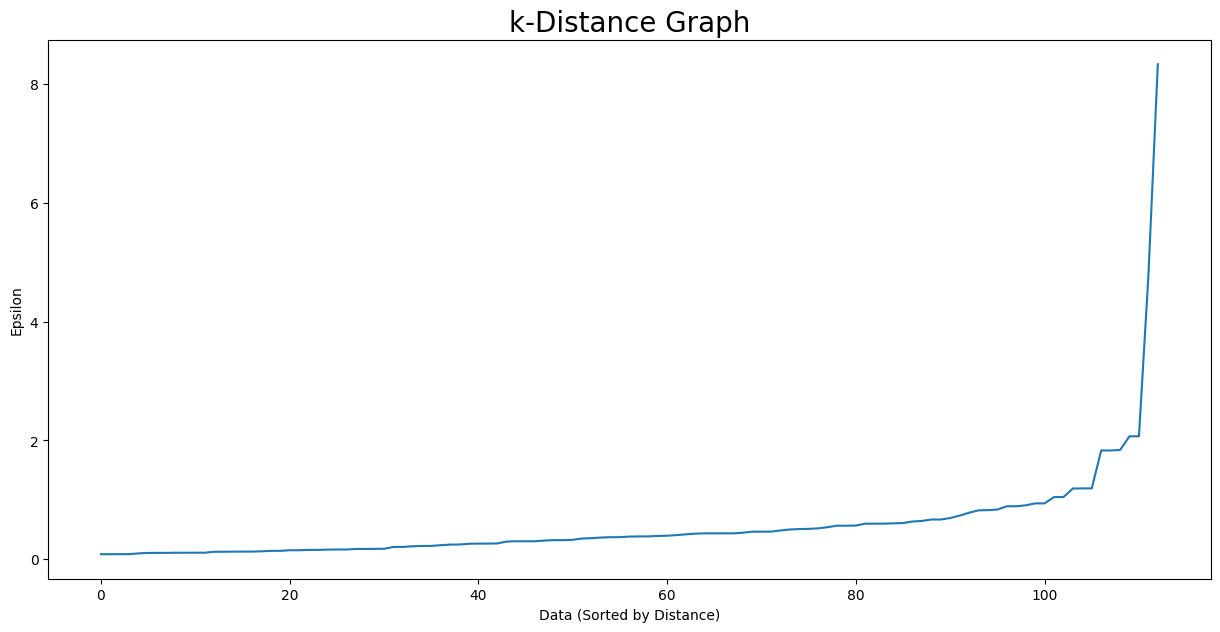

In [5]:
without_outliers, outliers = Outliers.remove_outliers(
    names, scaled_df, True
)

## Hierarchical Clustering Algorithms

In this section, hierarchical clustering of the countries is performed with four different linkage methods, namely complete, average, single and ward linkage.

For each linkage method, the distance threshold for splitting clusters is determined by MATLAB(TM). Namely the threshold is set to $0.7 * \text{max}(\text{distance})$. The number of clusters, the distribution of values and the silhoutte score are printed for each algorithm. Furthermore, the hierarchy is printed in the form of a dendogram to visualize the clusters.

### Complete Linkage

Number of Clusters: 4
Cluster Sizes: [35 33 37  3]
Silhouette Score: 0.31244205922800883


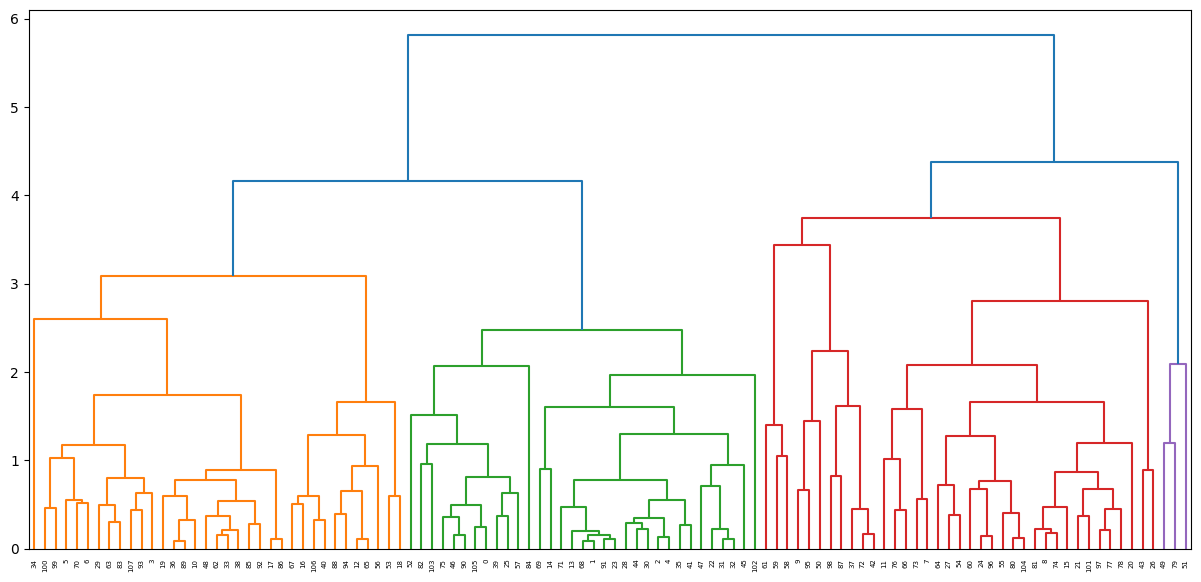

In [6]:
complete_labels, complete_score = HierarchicalClustering.hierarchical_clustering(
    without_outliers, 'complete', True
)

### Average Linkage

Number of Clusters: 4
Cluster Sizes: [ 3 13 91  1]
Silhouette Score: 0.2808960586498438


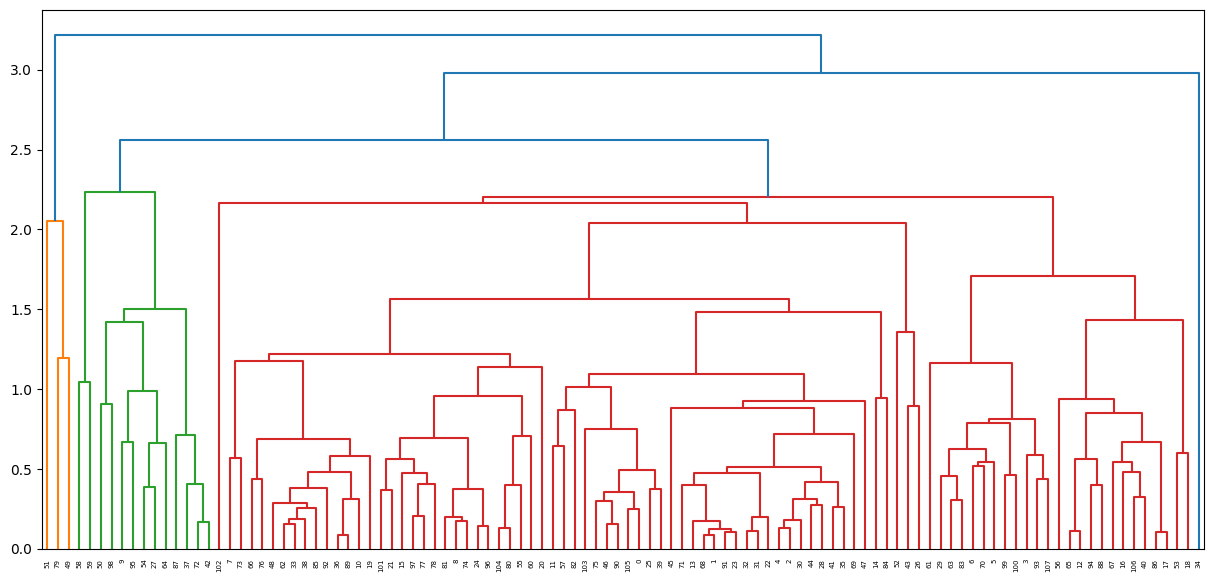

In [7]:
average_labels, average_score = HierarchicalClustering.hierarchical_clustering(
    without_outliers, 'average', True
)

### Single Linkage

Number of Clusters: 3
Cluster Sizes: [106   1   1]
Silhouette Score: 0.3326768364865931


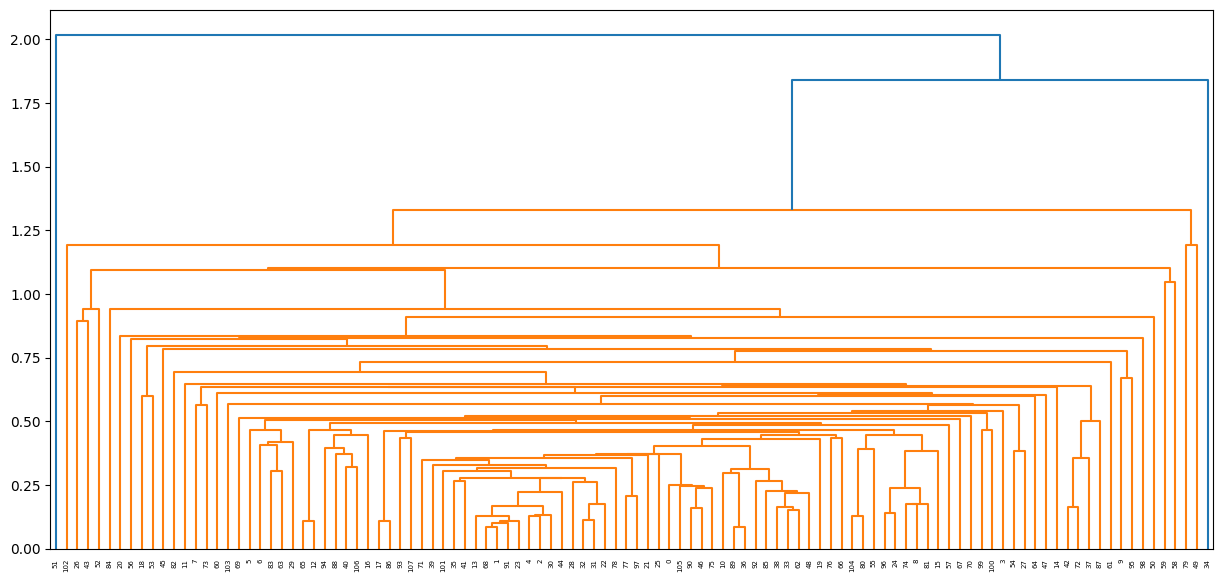

In [8]:
single_labels, single_score = HierarchicalClustering.hierarchical_clustering(
    without_outliers, 'single', True
)

### Ward Linkage

Number of Clusters: 3
Cluster Sizes: [51 13 44]
Silhouette Score: 0.3557479441018931


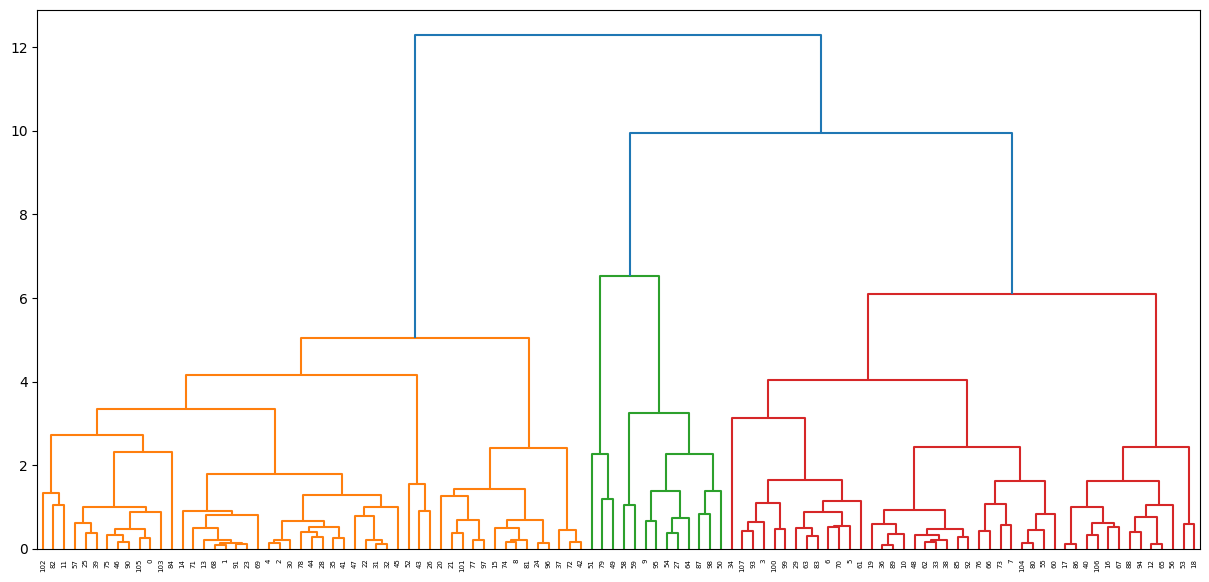

In [9]:
ward_labels, ward_score = HierarchicalClustering.hierarchical_clustering(
    without_outliers, 'ward', True
)

## Conclusion

In conclusion, it seems like ward linkage is better suited for this problem, as it produces more balanced clusters and achieves the highest silhoutte score. This applies to 108 countries, since China, Indonesia, India, Iran and Vietnam are considered outliers.